In [2]:
using LinearAlgebra
# using Plots
using Random
using StateSpaceDynamics
using Plots

const SSD = StateSpaceDynamics

StateSpaceDynamics

In [ ]:
# Define parameters
num_trials = 50  # Number of trials
trial_length = 1000  # Number of time steps per trial

# Create the emission models
emission_1 = PoissonRegressionEmission(;
    input_dim=3, output_dim=1, include_intercept=true, β=reshape([4, 3, 2, 4], :, 1)
)
emission_2 = PoissonRegressionEmission(;
    input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 1, 3], :, 1)
)

# Initialize the SwitchingPoissonRegression model
true_model = SwitchingPoissonRegression(; K=2, input_dim=3, output_dim=1)
true_model.A = [0.9 0.1; 0.2 0.8]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Create lists to hold data and labels for each trial
Φ_trials = [randn(3, trial_length) for _ in 1:num_trials]  # Input features for each trial
true_labels_trials = Vector{Vector{Int}}(undef, num_trials)
data_trials = Vector{Matrix{Float64}}(undef, num_trials)

# Sample data for each trial
for i in 1:num_trials
    true_labels_trials[i], data_trials[i] = StateSpaceDynamics.sample(
        true_model, Φ_trials[i]; n=trial_length
    )
end

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(; K=2, input_dim=3, output_dim=1)

# Initialize the emission models for warm start
emission_1 = PoissonRegressionEmission(;
    input_dim=3,
    output_dim=1,
    include_intercept=true,
    β=reshape([2.0, 1.0, 4.0, 2.0], :, 1),
)
emission_2 = PoissonRegressionEmission(;
    input_dim=3,
    output_dim=1,
    include_intercept=true,
    β=reshape([-5.0, -1.0, 0.0, 2.0], :, 1),
)
test_model.B[1], test_model.B[2] = emission_1, emission_2

# Fit the model using data from all trials
ll = StateSpaceDynamics.fit!(test_model, data_trials, Φ_trials; max_iters=200)

# Gaussian HMM

In [6]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

output_dim = 2
μ = [0.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_3 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)
#
# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=10000
true_labels, data = SSD.sample(true_model, n=n)

# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
# test_model.B[1] = emission_1
test_model.A = [0.4 0.6; 0.7 0.3]
lls = SSD.fit!(test_model, data)

print(isapprox(test_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, true_model.B[2].μ, atol=0.1))
print(isapprox(test_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, true_model.B[1].μ, atol=0.1))

truetrue

In [37]:
test_model.B[2].μ

2-element Vector{Float64}:
 1.996792362755173
 0.9899091291424154

In [45]:
lls = [-Inf]
data = (data,)
# transpose data so that correct dimensions are passed to EmissionModels.jl, a bit hacky but works for now.
transpose_data = Matrix.(transpose.(data))

num_obs = size(transpose_data[1], 1)
# initialize forward backward storage
FB_storage = SSD.initialize_forward_backward(test_model, num_obs)

SSD.estep!(test_model, transpose_data, FB_storage)

In [50]:
FB_storage.α

2×10000 Matrix{Float64}:
 -436.323         0.240644   -0.572088  …  -8587.79  -8587.75  -8612.11
   -0.00823141  -26.347     -17.1795       -8609.28  -8618.49  -8590.46

In [48]:
transpose_data[1]

10000×2 Matrix{Float64}:
  2.25584     0.837458
  0.0196819  -0.0816484
  0.361558    0.320145
  1.43208     0.69254
 -0.04613    -0.276725
  0.440059    0.132799
  1.74184     1.72583
  1.97492     0.761777
 -0.255154    0.186409
  0.069949   -0.0889173
  ⋮          
 -0.169008   -0.391008
  0.361558   -0.179718
  2.06916     0.995074
 -0.397545   -0.112927
  1.81584     1.34284
  0.339271   -0.0533657
  0.300483   -0.051962
 -0.240998    0.086352
  2.12374     0.617698

In [4]:
SSD.emission_loglikelihoods!(test_model, FB_storage, transpose_data...)
FB_storage.loglikelihoods

2×10000 Matrix{Float64}:
 -15.8482   -0.205209  -0.159205  …  -0.248589  -3.90579  -24.8337
  -3.46916  -1.90487   -1.90027      -1.90921   -2.27493   -4.36772

In [5]:
SSD.forward!(test_model, FB_storage)
FB_storage.α

2×10000 Matrix{Float64}:
 -18.3935   -6.7518   -6.93775  -7.88035  …  -14167.7  -14171.8  -14196.7
  -3.55086  -5.50702  -7.39972  -9.12288     -14170.5  -14171.3  -14175.6

In [6]:
SSD.backward!(test_model, FB_storage)
FB_storage.β

2×10000 Matrix{Float64}:
 -14169.5  -14169.1  -14168.7  -14167.7  …  -8.44509  -8.15078  -5.97716  0.0
 -14172.0  -14171.6  -14171.1  -14170.2     -8.63799  -6.74307  -4.41901  0.0

In [7]:
SSD.calculate_γ!(test_model, FB_storage)
FB_storage.γ

2×10000 Matrix{Float64}:
 -12.3159      -0.249621  -0.0573202  …  -0.220628  -2.17216  -21.1544
  -4.47991e-6  -1.51003   -2.88763       -1.61956   -0.12096   -6.49379e-10

In [15]:
"""
Find the nearest covariance matrix to matrix A in Frobenius norm using Higham's algorithm.

Arguments:
- `A`: Input matrix (should be square)
- `max_iter`: Maximum number of iterations
- `tol`: Convergence tolerance

Returns:
- The nearest covariance matrix to A
"""
function nearest_covariance_matrix(A; max_iter=100, tol=1e-6)
    # Convert to Matrix{Float64} to ensure numerical stability
    A = convert(Matrix{Float64}, A)
    n = size(A, 1)
    
    # Symmetrize A
    A = (A + A') / 2
    
    # Initial projection onto PSD cone
    F = eigen(Symmetric(A))
    eigvals = max.(F.values, 0)
    X = F.vectors * Diagonal(eigvals) * F.vectors'
    
    # Initialize Dykstra's correction matrices
    Y = zeros(n, n)
    S = zeros(n, n)
    
    for _ in 1:max_iter
        X_old = copy(X)
        
        # Project onto symmetric matrices with unit diagonal
        R = X - Y
        R = (R + R') / 2  # Ensure symmetry
        Y = R - Diagonal(diag(R)) + I
        
        # Project onto PSD cone
        R = Y - S
        F = eigen(Symmetric(R))
        eigvals = max.(F.values, 0)
        X = F.vectors * Diagonal(eigvals) * F.vectors'
        S = X - R
        
        # Check convergence using Frobenius norm
        if norm(X - X_old) < tol
            break
        end
    end
    
    # Ensure perfect symmetry in output
    return (X + X') / 2
end

nearest_covariance_matrix

In [ ]:
"""
Find nearest covariance matrix by simple eigenvalue projection.
Just sets negative eigenvalues to zero.
"""
function enforce_posdef(A)
    # Symmetrize first
    A = (A + A') / 2
    
    # Eigendecomposition and fix negative eigenvalues
    F = eigen(Symmetric(A))
    eigvals = max.(F.values, 0)
    return F.vectors * Diagonal(eigvals) * F.vectors'
end

nearest_covariance_simple

In [33]:
nearest_covariance_matrix([0.98 0.92; 0.92 1.0])

2×2 Matrix{Float64}:
 1.0          1.66533e-16
 1.66533e-16  1.0

In [42]:
nearest_covariance_simple(rand(4, 4))

4×4 Matrix{Float64}:
 0.764114  0.624749  0.628557  0.715401
 0.624749  0.673734  0.345721  0.488553
 0.628557  0.345721  0.828511  0.593067
 0.715401  0.488553  0.593067  0.792134

In [1]:
using LinearAlgebra
# using Plots
using Random
using StateSpaceDynamics


const SSD = StateSpaceDynamics

StateSpaceDynamics

# Section for timing and memory improvements of forward backward

In [10]:
"""
Sample from true model and initialize model to fit
"""

# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 100
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

"""
Time the forward backward algorithm
"""
X=Φ
Y=data
lls = [-Inf]

SSD.fit!(test_model, data, Φ)

# model=test_model
# data = X === nothing ? (Y,) : (X, Y)
# # transpose data so that correct dimensions are passed to EmissionModels.jl, a bit hacky but works for now.
# transpose_data = Matrix.(transpose.(data))
# log_likelihood = -Inf



100


4-element Vector{Float64}:
   -Inf
 -1459.014642217791
  -689.4429633312888
  -689.4429633312888

In [ ]:
num_obs = size(transpose_data[1], 1)
FB_storage = SSD.initialize_forward_backward(model, num_obs)

In [21]:
# Using a local reference
function emission_loglikelihoods!(model::HiddenMarkovModel, FB_storage::SSD.ForwardBackward, data)
    loglikelihoods = FB_storage.loglikelihoods
    for k in 1:model.K
        loglikelihoods[k, :] .= loglikelihood(model.B[k], data...)
    end
end

function emission_loglikelihoods2!(model::HiddenMarkovModel, FB_storage::SSD.ForwardBackward, data)
    for k in 1:model.K
        FB_storage.loglikelihoods[k, :] .= loglikelihood(model.B[k], data...)
    end
end

emission_loglikelihoods2! (generic function with 2 methods)

In [58]:
@time emission_loglikelihoods!(model, FB_storage, transpose_data)
@time emission_loglikelihoods2!(model, FB_storage, transpose_data)

  0.000144 seconds (38 allocations: 314.812 KiB)
  0.000154 seconds (38 allocations: 314.812 KiB)


In [17]:
size(transpose_data[1])[1]

2000

In [3]:
@time γ, ξ, α, β = estep(model, transpose_data);

  1.684387 seconds (2.63 M allocations: 171.443 MiB, 1.31% gc time, 265.26% compilation time)


In [19]:
# compute lls of the observations
println("emission_loglikelihoods stats:")
@time loglikelihoods = SSD.emission_loglikelihoods(model, transpose_data...);

# run forward-backward algorithm
println("forward stats:")
@time α = SSD.forward(model, loglikelihoods);

println("backward stats:")
@time β = SSD.backward(model, loglikelihoods);

println("γ stats:")
@time γ = SSD.calculate_γ(model, α, β)

println("ξ stats:")
@time ξ = SSD.calculate_ξ(model, α, β, loglikelihoods)


emission_loglikelihoods stats:
  0.000186 seconds (113 allocations: 354.211 KiB)
forward stats:
  0.000715 seconds (31.99 k allocations: 531.125 KiB)
backward stats:
  0.000830 seconds (47.98 k allocations: 781.000 KiB)
γ stats:
  0.377217 seconds (273.81 k allocations: 18.531 MiB, 443.97% compilation time)
ξ stats:
  0.124611 seconds (335.17 k allocations: 20.343 MiB, 8.55% gc time, 99.45% compilation time)


2×2×1999 Array{Float64, 3}:
[:, :, 1] =
 -2.50659  -0.937908
 -2.49195  -0.811346

[:, :, 2] =
 -3.564    -1.99532
 -2.03089  -0.350286

[:, :, 3] =
 -3.59334  -2.02467
 -2.02522  -0.344618

;;; … 

[:, :, 1997] =
 -3.59381  -2.02513
 -2.02513  -0.34453

[:, :, 1998] =
 -3.59381  -2.02513
 -2.02513  -0.34453

[:, :, 1999] =
 -3.59381  -2.02513
 -2.02513  -0.34453

# Switching Gaussian Regression #

In [2]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
println(test_model.A)
ll = SSD.fit!(test_model, data, Φ)

# # Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

[0.3347745603700436 0.6652254396299563; 0.16428961944054915 0.8357103805594508]
truetrue

# Switching Multivariate Gaussian Regression

In [50]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=50, output_dim=100, include_intercept=true, β=50*rand(51, 100))
emission_2 = GaussianRegressionEmission(input_dim=50, output_dim=100, include_intercept=true, β=-30*rand(51, 100))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=50, output_dim=100, include_intercept=true)
true_model.A = [0.6 0.4; 0.3 0.7]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(50, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=50, output_dim=100, include_intercept=true)
test_model.A = [0.9999 0.1111; 0.8888 0.2222]
ll = SSD.fit!(test_model, data, Φ)

# # # Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

falsefalse

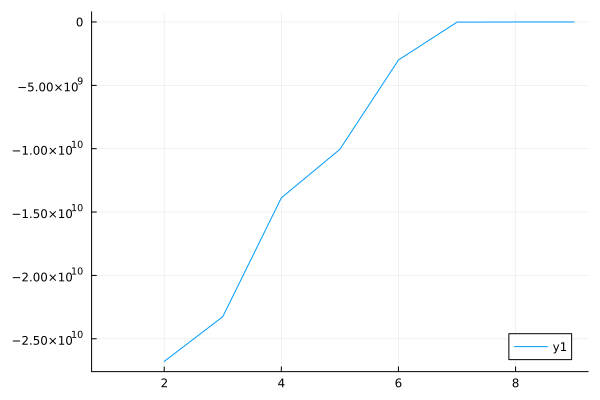

In [51]:
plot(ll)

# Trialized Multivariate Switching Gaussian Regression Model

In [18]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=50, output_dim=100, include_intercept=true, β=50*rand(51, 100))
emission_2 = GaussianRegressionEmission(input_dim=50, output_dim=100, include_intercept=true, β=-30*rand(51, 100))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=5, input_dim=50, output_dim=100, include_intercept=true)
# true_model.A = [0.6 0.4; 0.3 0.7]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample trials from the model 100 time points 50 trials or something
num_trials = 10  # Number of times you want to sample
n = 100


all_labels = Vector{Matrix{Int}}()  # Store each true_labels matrix
all_data = Vector{Matrix{Float64}}()  # Store each data matrix
Φ_total = Vector{Matrix{Float64}}()

for _ in 1:num_trials
    Φ = randn(50, n)
    true_labels, data = SSD.sample(true_model, Φ, n=n)
    # push!(all_labels, true_labels)
    push!(all_data, data)
    push!(Φ_total, Φ)
end


# # Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=5, input_dim=50, output_dim=100, include_intercept=true)
# test_model.A = [.1111 0.9999; 0.2222 0.8888]
ll = SSD.fit!(test_model, all_data, Φ_total)

# # # Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:03 (39.29 ms/it)


falsefalse

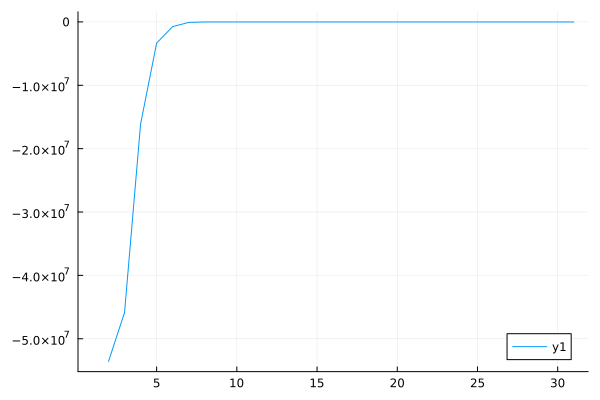

In [19]:
plot(ll)

In [5]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[1 2; 1 2; 1 2])
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[2 1; 2 1; 2 1])

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=2, include_intercept=false)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=2, include_intercept=false)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[1.0 2.0; 1.0 2.0; 1.0 2.0])
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[2.0 1.0; 2.0 1.0; 2.0 1.0])
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=100)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))


Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:01:56 ( 1.16  s/it)


truetrue

# Switching Bernoulli Regression #

In [19]:
# Make Emission Models
emission_1 = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([3, 1, 2], :, 1))
emission_2 = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([-3, -2, 0.1], :, 1))

# Create Switching Bernoulli Regression and add the emissions
true_model = StateSpaceDynamics.SwitchingBernoulliRegression(K=2, input_dim=2)
true_model.A = [0.9 0.1; 0.2 0.8]
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n=20000
Φ = randn(2, n)
true_labels, data = StateSpaceDynamics.sample(true_model, Φ, n=n)

# Fit a new Bernoulli Regression Model to the data
test_model = StateSpaceDynamics.SwitchingBernoulliRegression(K=2, input_dim=2, λ=1.0)
test_model.A = [0.75 0.25; 0.1 0.9]
test_model.B[1] = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([2.5, 0.25, 1.0], :, 1))
test_model.B[2] = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([-2.0, -3.0, -1.0], :, 1))
ll = StateSpaceDynamics.fit!(test_model, data, Φ, max_iters=200)
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.2) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.2))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.2) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.2))


truetrue

# Switching Poisson Regression

In [20]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([4, 3, 2, 4], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 1, 3], :, 1))

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([2.0, 1.0, 4.0, 2.0], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-5.0, -1.0, 0.0, 2.0], :, 1))
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=200)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))


truetrue